In [41]:
# install and import libs

import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas_gbq

In [ ]:
# load data

project_id = "xq-data-bigquery"
sql = """
with dependent_cte as
(select cds_code, lower(trim(reporting_category)) as reporting_category, perc_graduate
from `dataform_intermediate_xq_school_data.int_ca_doe_graduation_rate`
where year = '2023-24'
  and perc_graduate <> 700
  and dass like 'No%'
  and reporting_category in ("African American","American Indian or Alaska Native", "Asian", "Filipino","Hispanic or Latino","Pacific Islander","Two or More Races","White","Socioeconomically Disadvantaged","Female","Male")),

ind_elascores_cte as
(select
  cds_code,
  lower(trim((case when student_group_name = 'Native Hawaiian or Pacific Islander' then 'Pacific Islander'
    when student_group_name = 'Homeless' then 'Homeless Youth'
    when student_group_name = 'Black or African American' then 'African American'
    else student_group_name end))) as student_group_name_mod,
  (IF(perc_met_standard=700 or perc_exceeded_standard=700,NULL,perc_met_standard + perc_exceeded_standard)) as perc_ela_proficient
from `dataform_intermediate_xq_school_data.int_ca_doe_sbac_proficiency`
where year = '2022-23'
  and grade = 11
  and test_subject = 'ELA'
  and student_group_name in ("Black or African American","American Indian or Alaska Native", "Asian", "Filipino","Hispanic or Latino","Native Hawaiian or Pacific Islander","Two or More Races","White","Socioeconomically Disadvantaged","Female","Male")),

ind_mathscores_cte as
(select
  cds_code,
  lower(trim((case when student_group_name = 'Native Hawaiian or Pacific Islander' then 'Pacific Islander'
    when student_group_name = 'Homeless' then 'Homeless Youth'
    when student_group_name = 'Black or African American' then 'African American'
    else student_group_name end))) as student_group_name_mod,
  (IF(perc_met_standard=700 or perc_exceeded_standard=700,NULL,perc_met_standard + perc_exceeded_standard)) as perc_math_proficient
from `dataform_intermediate_xq_school_data.int_ca_doe_sbac_proficiency`
where year = '2022-23'
  and grade = 11
  and test_subject = 'Math'
  and student_group_name in ("Black or African American","American Indian or Alaska Native", "Asian", "Filipino","Hispanic or Latino","Native Hawaiian or Pacific Islander","Two or More Races","White","Socioeconomically Disadvantaged","Female","Male")),

ind_stability_cte as
(select cds_code, lower(trim(reporting_category)) as reporting_category, perc_stable_students
from `dataform_intermediate_xq_school_data.int_ca_doe_stability_rate`
where year = '2022-23'
  and perc_stable_students <> 700
  and reporting_category in ("African American","American Indian or Alaska Native", "Asian", "Filipino","Hispanic or Latino","Pacific Islander","Two or More Races","White","Socioeconomically Disadvantaged","Female","Male")),

ind_absenteeism_cte as
(select cds_code, lower(trim(reporting_category)) as reporting_category, perc_chronic_absenteeism
from `dataform_intermediate_xq_school_data.int_ca_doe_chronic_absenteeism`
where year = '2022-23'
  and perc_chronic_absenteeism <> 700
  and reporting_category in ("African American","American Indian or Alaska Native", "Asian", "Filipino","Hispanic or Latino","Pacific Islander","Two or More Races","White","Socioeconomically Disadvantaged","Female","Male")),

ind_suspensions_cte as
(select cds_code, lower(trim(reporting_category)) as reporting_category, perc_students_suspended
from `dataform_intermediate_xq_school_data.int_ca_doe_suspension_rate`
where year = '2022-23'
  and perc_students_suspended <> 700
  and reporting_category in ("African American","American Indian or Alaska Native", "Asian", "Filipino","Hispanic or Latino","Pacific Islander","Two or More Races","White","Socioeconomically Disadvantaged","Female","Male"))

select
  dependent_cte.cds_code,
  dependent_cte.reporting_category,
  perc_ela_proficient,
  perc_math_proficient,
  perc_stable_students,
  perc_chronic_absenteeism,
  perc_students_suspended,
  perc_graduate
from dependent_cte
  left join ind_elascores_cte on dependent_cte.cds_code = ind_elascores_cte.cds_code
    and dependent_cte.reporting_category = ind_elascores_cte.student_group_name_mod
  left join ind_mathscores_cte on dependent_cte.cds_code = ind_mathscores_cte.cds_code
    and dependent_cte.reporting_category = ind_mathscores_cte.student_group_name_mod
  left join ind_stability_cte on dependent_cte.cds_code = ind_stability_cte.cds_code
    and dependent_cte.reporting_category = ind_stability_cte.reporting_category
  left join ind_absenteeism_cte on dependent_cte.cds_code = ind_absenteeism_cte.cds_code
    and dependent_cte.reporting_category = ind_absenteeism_cte.reporting_category
  left join ind_suspensions_cte on dependent_cte.cds_code = ind_suspensions_cte.cds_code
    and dependent_cte.reporting_category = ind_suspensions_cte.reporting_category;
"""
df = pandas_gbq.read_gbq(sql, project_id=project_id, dialect="standard")

Downloading: 100%|██████████|


In [44]:
# dq check

print(df.head())
print(df.info())
df = df.astype({'perc_ela_proficient': float, 'perc_math_proficient': float, 'perc_chronic_absenteeism': float, 'perc_students_suspended': float, 'perc_graduate': float, 'perc_stable_students': float})

df['perc_ela_proficient'] = df['perc_ela_proficient'].fillna(df['perc_ela_proficient'].mean())
df['perc_math_proficient'] = df['perc_math_proficient'].fillna(df['perc_math_proficient'].mean())
df_clean = df.dropna(subset=['perc_stable_students','perc_chronic_absenteeism','perc_students_suspended'])
print(df_clean.info())

         cds_code                reporting_category perc_ela_proficient  \
0  34674473430717  american indian or alaska native           58.475915   
1  01611920135319                  pacific islander        54.540000000   
2  01612420134668                  pacific islander        33.330000000   
3  15635290110999                  pacific islander        91.670000000   
4  34674393434768                  pacific islander        28.570000000   

  perc_math_proficient perc_stable_students perc_chronic_absenteeism  \
0            28.864832         62.100000000             21.800000000   
1          9.090000000         88.500000000             36.000000000   
2         13.330000000         85.900000000             54.000000000   
3         50.000000000         91.900000000              8.100000000   
4          7.140000000         81.000000000             43.900000000   

  perc_students_suspended  perc_graduate  
0                    0E-9   58.300000000  
1             7.700000000   75

In [45]:
# get dummy variables

df_clean_dummy = pd.get_dummies(df_clean, columns = ['reporting_category'],dtype=float)
print(df_clean_dummy.head())

         cds_code  perc_ela_proficient  perc_math_proficient  \
0  34674473430717            58.475915             28.864832   
1  01611920135319            54.540000              9.090000   
2  01612420134668            33.330000             13.330000   
3  15635290110999            91.670000             50.000000   
4  34674393434768            28.570000              7.140000   

   perc_stable_students  perc_chronic_absenteeism  perc_students_suspended  \
0                  62.1                      21.8                      0.0   
1                  88.5                      36.0                      7.7   
2                  85.9                      54.0                      9.4   
3                  91.9                       8.1                     16.2   
4                  81.0                      43.9                     16.7   

   perc_graduate  reporting_category_african american  \
0           58.3                                  0.0   
1           75.0                

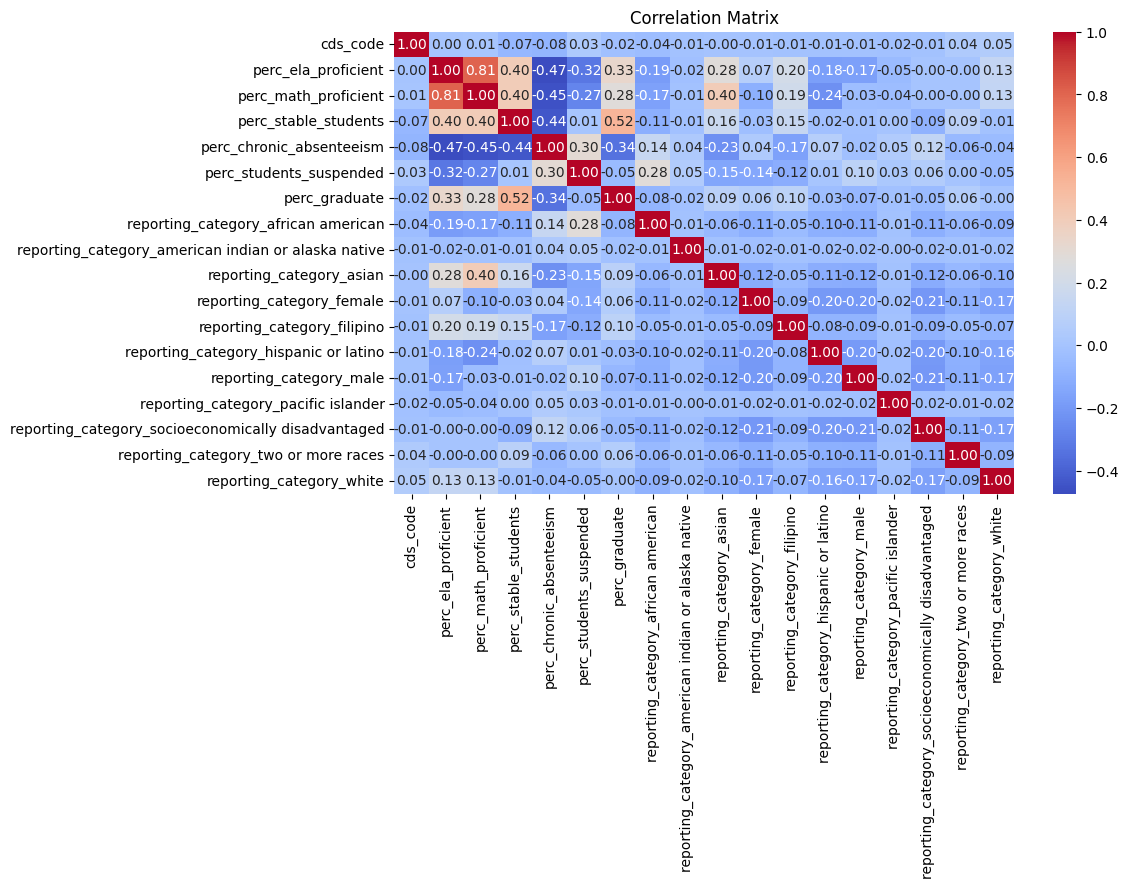

In [46]:
# check correlation

plt.figure(figsize=(10,6))
sns.heatmap(df_clean_dummy.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# math and ela test correlation > .7 (multicollinearity)
df_clean_dummy['perc_proficient'] = (df_clean_dummy['perc_ela_proficient'] + df_clean_dummy['perc_math_proficient']) / 2

In [54]:
# run multiple linear regression

print(df_clean_dummy.head())

X = df_clean_dummy[['perc_proficient', 'perc_stable_students', 'perc_chronic_absenteeism', 'perc_students_suspended', 'reporting_category_african american', 'reporting_category_american indian or alaska native', 'reporting_category_asian', 'reporting_category_female', 'reporting_category_filipino', 'reporting_category_hispanic or latino', 'reporting_category_male', 'reporting_category_pacific islander', 'reporting_category_socioeconomically disadvantaged', 'reporting_category_two or more races', 'reporting_category_white']] # removed male to avoid multicollinearity
y = df_clean_dummy[['perc_graduate']]
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

         cds_code  perc_ela_proficient  perc_math_proficient  \
0  34674473430717            58.475915             28.864832   
1  01611920135319            54.540000              9.090000   
2  01612420134668            33.330000             13.330000   
3  15635290110999            91.670000             50.000000   
4  34674393434768            28.570000              7.140000   

   perc_stable_students  perc_chronic_absenteeism  perc_students_suspended  \
0                  62.1                      21.8                      0.0   
1                  88.5                      36.0                      7.7   
2                  85.9                      54.0                      9.4   
3                  91.9                       8.1                     16.2   
4                  81.0                      43.9                     16.7   

   perc_graduate  reporting_category_african american  \
0           58.3                                  0.0   
1           75.0                

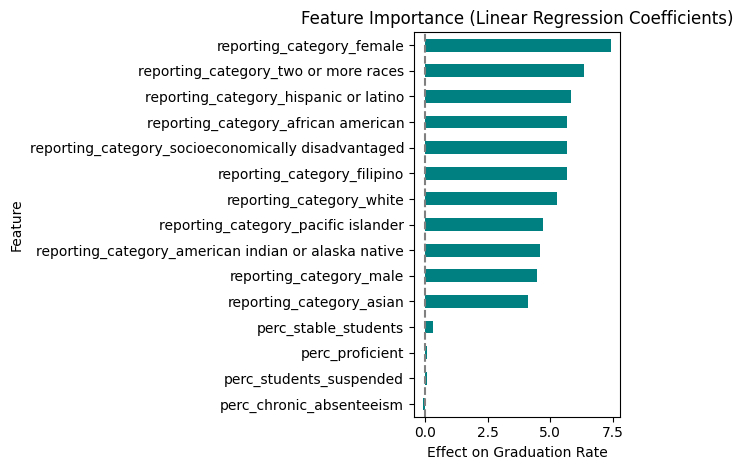

In [55]:
# feature importance

coefs = model.params.drop('const')  # Exclude intercept
coefs.sort_values().plot(kind='barh', color='teal')
plt.title("Feature Importance (Linear Regression Coefficients)")
plt.xlabel("Effect on Graduation Rate")
plt.ylabel("Feature")
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()